# Bayesian Optimization

[Bayesian optimization](https://en.wikipedia.org/wiki/Bayesian_optimization) is a powerful strategy for minimizing (or maximizing) objective functions that are costly to evaluate.  It is an important component of [automated machine learning](https://en.wikipedia.org/wiki/Automated_machine_learning) toolboxes such as [auto-sklearn](https://automl.github.io/auto-sklearn/stable/), [auto-weka](http://www.cs.ubc.ca/labs/beta/Projects/autoweka/), and [scikit-optimize](https://scikit-optimize.github.io/), where Bayesian optimization is used to select model hyperparameters. Bayesian optimization is used for a wide range of other applications as well; as cataloged in the review [2], these include interactive user-interfaces, robotics, environmental monitoring, information extraction, combinatorial optimization, sensor networks, adaptive Monte Carlo, experimental design, and reinforcement learning.

## Problem Setup

We are given a minimization problem

$$ x^* = \text{arg}\min \ f(x), $$

where $f$ is a fixed objective function that we can evaluate pointwise. 
Here we assume that we do _not_  have access to the gradient of $f$. We also
allow for the possibility that evaluations of $f$ are noisy.

To solve the minimization problem, we will construct a sequence of points $\{x_n\}$ that converge to $x^*$. Since we implicitly assume that we have a fixed budget (say 100 evaluations), we do not expect to find the exact minumum $x^*$: the goal is to get the best approximate solution we can given the allocated budget.

The Bayesian optimization strategy works as follows:

1. Place a prior on the objective function $f$. Each time we evaluate $f$ at a new point $x_n$, we update our model for $f(x)$. This model serves as a surrogate objective function and reflects our beliefs about $f$ (in particular it reflects our beliefs about where we expect $f(x)$ to be close to $f(x^*)$). Since we are being Bayesian, our beliefs are encoded in a posterior that allows us to systematically reason about the uncertainty of our model predictions.

2. Use the posterior to derive an "acquisition" function $\alpha(x)$ that is easy to evaluate and differentiate (so that optimizing $\alpha(x)$ is easy). In contrast to $f(x)$, we will generally evaluate $\alpha(x)$ at many points $x$, since doing so will be cheap.

3. Repeat until convergence:

    + Use the acquisition function to derive the next query point according to
    $$ x_{n+1} = \text{arg}\min \ \alpha(x). $$

    + Evaluate $f(x_{n+1})$ and update the posterior.

A good acquisition function should make use of the uncertainty encoded in the posterior to encourage a balance between exploration&mdash;querying points where we know little about $f$&mdash;and exploitation&mdash;querying points in regions we have good reason to think $x^*$ may lie. As the iterative procedure progresses our model for $f$ evolves and so does the acquisition function. If our model is good and we've chosen a reasonable acquisition function, we expect that the acquisition function will guide the query points $x_n$ towards $x^*$.

In this tutorial, our model for $f$ will be a Gaussian process. In particular we will see how to use the [Gaussian Process module](http://docs.pyro.ai/en/0.2.0-release/contrib.gp.html) in Pyro to implement a simple Bayesian optimization procedure.

In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import torch
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import constraints, transform_to

import pyro
import pyro.contrib.gp as gp

pyro.enable_validation(True)  # can help with debugging
pyro.set_rng_seed(1)

## Define an objective function

For the purposes of demonstration, the objective function we are going to consider is the [Forrester et al. (2008) function](https://www.sfu.ca/~ssurjano/forretal08.html):

$$f(x) = (6x-2)^2 \sin(12x-4), \quad x\in [0, 1].$$

This function has both a local minimum and a global minimum. The global minimum is at $x^* = 0.75725$.

In [2]:
def f(x):
    return (6 * x - 2)**2 * torch.sin(12 * x - 4)

Let's begin by plotting $f$.

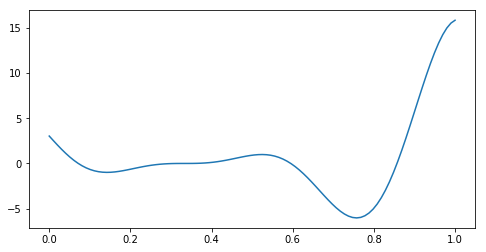

In [3]:
x = torch.linspace(0, 1)
plt.figure(figsize=(8, 4))
plt.plot(x.numpy(), f(x).numpy())
plt.show()

## Setting a Gaussian Process prior

[Gaussian processes](https://en.wikipedia.org/wiki/Gaussian_process) are a popular choice for a function priors due to their power and flexibility. The core of a Gaussian Process is its covariance function $k$, which governs the similarity of $f(x)$ for pairs of input points. Here we will use a Gaussian Process as our prior for the objective function $f$. Given inputs $X$ and the corresponding noisy observations $y$, the model takes the form

$$f\sim\mathrm{MultivariateNormal}(0,k(X,X)),$$

$$y\sim f+\epsilon,$$

where $\epsilon$ is i.i.d. Gaussian noise and $k(X,X)$ is a covariance matrix whose entries are given by $k(x,x^\prime)$ for each pair of inputs $(x,x^\prime)$.

We choose the [Matern](https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function) kernel with $\nu = \frac{5}{2}$ (as suggested in reference [1]). Note that the popular [RBF](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) kernel, which is used in many regression tasks, results in a function prior whose samples are infinitely differentiable; this is probably an unrealistic assumption for most 'black-box' objective functions.

In [4]:
# initialize the model with four input points: 0.0, 0.33, 0.66, 1.0
X = torch.tensor([0.0, 0.33, 0.66, 1.0])
y = f(X)
gpmodel = gp.models.GPRegression(X, y, gp.kernels.Matern52(input_dim=1),
                                 noise=torch.tensor(0.1), jitter=1.0e-4)

The following helper function `update_posterior` will take care of updating our `gpmodel` each time we evaluate $f$ at a new value $x$.

In [5]:
def update_posterior(x_new):
    y = f(x_new) # evaluate f at new point.
    X = torch.cat([gpmodel.X, x_new]) # incorporate new evaluation 
    y = torch.cat([gpmodel.y, y])     
    gpmodel.set_data(X, y)
    # optimize the GP hyperparameters using Adam optimizer
    optimizer = optim.Adam(gpmodel.parameters())
    gp.util.train(gpmodel, optimizer)

## Define an acquisition function

There are many reasonable options for the acquisition function (see references [1] and [2] for a list of popular choices and a discussion of their properties). Here we will use one that is 'simple to implement and interpret,' namely the 'Lower Confidence Bound' acquisition function. 
It is given by

$$
\alpha(x) = \mu(x) - \kappa \sigma(x)
$$

where $\mu(x)$ and $\sigma(x)$ are the mean and square root variance of the posterior at the point $x$, and the arbitrary constant $\kappa>0$ controls the trade-off between exploitation and exploration. This acquisition function will be minimized for choices of $x$ where either: i) $\mu(x)$ is small (exploitation); or ii) where $\sigma(x)$ is large (exploration).  A large value of $\kappa$ means that we place more weight on exploration because we prefer candidates $x$ in areas of high uncertainty. A small value of $\kappa$ encourages exploitation because we prefer candidates $x$ that minimize $\mu(x)$, which is the mean of our surrogate objective function. We will use $\kappa=2$.

In [6]:
def lower_confidence_bound(x, kappa=2):
    mu, variance = gpmodel(x, full_cov=False, noiseless=False)
    sigma = variance.sqrt()
    return mu - kappa * sigma

The final component we need is a way to find (approximate) minimizing points $x_{\rm min}$ of the acquisition function. There are several ways to proceed, including gradient-based and non-gradient-based techniques. Here we will follow the gradient-based approach. One of the possible drawbacks of gradient descent methods is that the minimization algorithm can get stuck at a local minimum. In this tutorial, we adopt a (very) simple approach to address this issue:

- First, we seed our minimization algorithm with 5 different values: i) one is chosen to be $x_{n-1}$, i.e. the candidate $x$ used in the previous step; and ii) four are chosen uniformly at random from the domain of the objective function. 
- We then run the minimization algorithm to approximate convergence for each seed value. 
- Finally, from the five candidate $x$s identified by the minimization algorithm, we select the one that minimizes the acquisition function.

Please refer to reference [2] for a more detailed discussion of this problem in Bayesian Optimization.

In [7]:
def find_a_candidate(x_init, lower_bound=0, upper_bound=1):
    # transform x to an unconstrained domain
    constraint = constraints.interval(lower_bound, upper_bound)
    unconstrained_x_init = transform_to(constraint).inv(x_init)
    unconstrained_x = unconstrained_x_init.clone().detach().requires_grad_(True)
    minimizer = optim.LBFGS([unconstrained_x])

    def closure():
        minimizer.zero_grad()
        x = transform_to(constraint)(unconstrained_x)
        y = lower_confidence_bound(x)
        autograd.backward(unconstrained_x, autograd.grad(y, unconstrained_x))
        return y
    
    minimizer.step(closure)
    # after finding a candidate in the unconstrained domain, 
    # convert it back to original domain.
    x = transform_to(constraint)(unconstrained_x)
    return x.detach()

## The inner loop of Bayesian Optimization

With the various helper functions defined above, we can now encapsulate the main logic of a single step of Bayesian Optimization in the function `next_x`:

In [8]:
def next_x(lower_bound=0, upper_bound=1, num_candidates=5):
    candidates = []
    values = []

    x_init = gpmodel.X[-1:]
    for i in range(num_candidates):
        x = find_a_candidate(x_init, lower_bound, upper_bound)
        y = lower_confidence_bound(x)
        candidates.append(x)
        values.append(y)
        x_init = x.new_empty(1).uniform_(lower_bound, upper_bound)

    argmin = torch.min(torch.cat(values), dim=0)[1].item()
    return candidates[argmin]

## Running the algorithm

To illustrate how Bayesian Optimization works, we make a convenient plotting function that will help us visualize our algorithm's progress.

In [9]:
def plot(gs, xmin, xlabel=None, with_title=True):
    xlabel = "xmin" if xlabel is None else "x{}".format(xlabel)
    Xnew = torch.linspace(-0.1, 1.1)
    ax1 = plt.subplot(gs[0])
    ax1.plot(gpmodel.X.numpy(), gpmodel.y.numpy(), "kx")  # plot all observed data
    with torch.no_grad():
        loc, var = gpmodel(Xnew, full_cov=False, noiseless=False)
        sd = var.sqrt()
        ax1.plot(Xnew.numpy(), loc.numpy(), "r", lw=2)  # plot predictive mean
        ax1.fill_between(Xnew.numpy(), loc.numpy() - 2*sd.numpy(), loc.numpy() + 2*sd.numpy(),
                         color="C0", alpha=0.3)  # plot uncertainty intervals
    ax1.set_xlim(-0.1, 1.1)
    ax1.set_title("Find {}".format(xlabel))
    if with_title:
        ax1.set_ylabel("Gaussian Process Regression")

    ax2 = plt.subplot(gs[1])
    with torch.no_grad():
        # plot the acquisition function
        ax2.plot(Xnew.numpy(), lower_confidence_bound(Xnew).numpy())
        # plot the new candidate point
        ax2.plot(xmin.numpy(), lower_confidence_bound(xmin).numpy(), "^", markersize=10,
                 label="{} = {:.5f}".format(xlabel, xmin.item()))  
    ax2.set_xlim(-0.1, 1.1)
    if with_title:
        ax2.set_ylabel("Acquisition Function")
    ax2.legend(loc=1)

Our surrogate model `gpmodel` already has 4 function evaluations at its disposal; however, we have yet to optimize the GP hyperparameters. So we do that first. Then in a loop we call the `next_x` and `update_posterior` functions repeatedly. The following plot illustrates how Gaussian Process posteriors and the corresponding acquisition functions change at each step in the algorith. Note how query points are chosen both for exploration and exploitation.

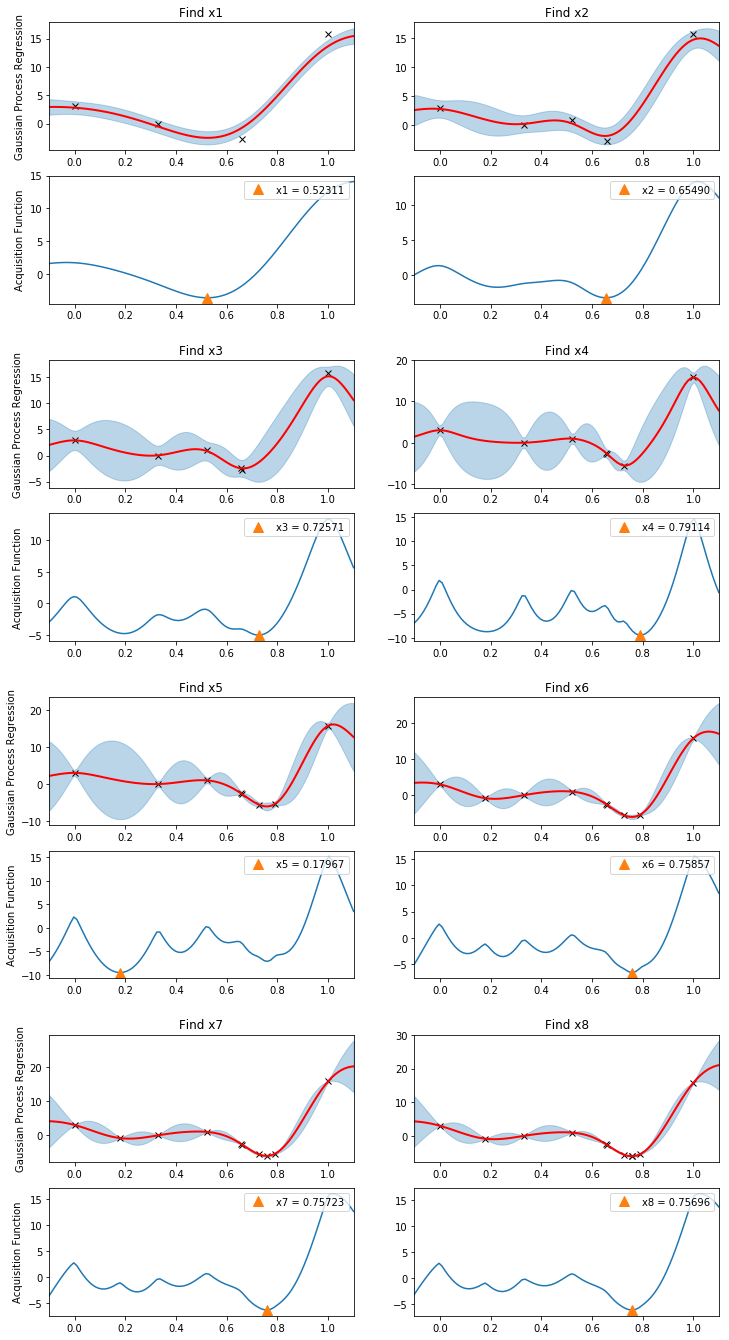

In [10]:
plt.figure(figsize=(12, 30))
outer_gs = gridspec.GridSpec(5, 2)
optimizer = optim.Adam(gpmodel.parameters())
gp.util.train(gpmodel, optimizer)
for i in range(8):
    xmin = next_x() 
    gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[i])
    plot(gs, xmin, xlabel=i+1, with_title=(i % 2 == 0))
    update_posterior(xmin)
plt.show()

Because we have assumed that our observations contain noise, it is improbable that we will find the exact minimizer of the function $f$. Still, with a relatively small budget of evaluations (12) we see that the algorithm has converged to very close to the global minimum at $x^* = 0.75725$. 

While this tutorial is only intended to be a brief introduction to Bayesian Optimization, we hope that we have been able to convey the basic underlying ideas. Consider watching the lecture by Nando de Freitas [3] for an excellent exposition of the basic theory. Finally, the reference paper [2] gives a review of recent research on Bayesian Optimization, together with many discussions about important technical details.

## References

[1] `Practical bayesian optimization of machine learning algorithms`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Jasper Snoek, Hugo Larochelle, and Ryan P. Adams

[2] `Taking the human out of the loop: A review of bayesian optimization`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Bobak Shahriari, Kevin Swersky, Ziyu Wang, Ryan P. Adams, and Nando De Freitas

[3] [Machine learning - Bayesian optimization and multi-armed bandits](https://www.youtube.com/watch?v=vz3D36VXefI)